In [1]:
import re
import sys
from time import time, sleep
from pprint import pprint
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

FILENAME = "main.cpp"

In [2]:
!cp ../answer/{FILENAME} ./{FILENAME}

In [3]:
#!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -o {FILENAME}.out

main.cpp:49: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
   49 | #pragma clang attribute push (__attribute__((target("arch=skylake"))),apply_to=function)
      | 
main.cpp:1656: warning: ignoring #pragma clang attribute [-Wunknown-pragmas]
 1656 | #pragma clang attribute pop
      | 
main.cpp: In function ‘void test::TestBitBoardGetSpeed()’:
main.cpp:852:9: warning: unused variable ‘t0’ [-Wunused-variable]
  852 |  double t0;
      |         ^~
main.cpp: In function ‘void globals::UpdateValueTable()’:
main.cpp:958:15: warning: unused variable ‘vm’ [-Wunused-variable]
  958 |   const auto& vm = v_modified[idx_RCSEV];
      |               ^~
main.cpp: In member function ‘void State::RecalcFutureScore()’:
main.cpp:1057:14: warning: unused variable ‘old_subscore2’ [-Wunused-variable]
 1057 |   const auto old_subscore2 = subscore2;
      |              ^~~~~~~~~~~~~
main.cpp: In function ‘void Solve()’:
main.cpp:1463:54: warning: suggest parentheses around ‘-’ in operand 

In [4]:
# テストケース生成
SEED = 0
N_TESTCASES = 500

!mkdir in
for i in range(N_TESTCASES):
    filename = f"{i:04d}.txt"
    seed = SEED + i
    !python3 ../A/tester/generator.py {seed} > ./in/{filename}
!ls in

0000.txt  0063.txt  0126.txt  0189.txt	0252.txt  0315.txt  0378.txt  0441.txt
0001.txt  0064.txt  0127.txt  0190.txt	0253.txt  0316.txt  0379.txt  0442.txt
0002.txt  0065.txt  0128.txt  0191.txt	0254.txt  0317.txt  0380.txt  0443.txt
0003.txt  0066.txt  0129.txt  0192.txt	0255.txt  0318.txt  0381.txt  0444.txt
0004.txt  0067.txt  0130.txt  0193.txt	0256.txt  0319.txt  0382.txt  0445.txt
0005.txt  0068.txt  0131.txt  0194.txt	0257.txt  0320.txt  0383.txt  0446.txt
0006.txt  0069.txt  0132.txt  0195.txt	0258.txt  0321.txt  0384.txt  0447.txt
0007.txt  0070.txt  0133.txt  0196.txt	0259.txt  0322.txt  0385.txt  0448.txt
0008.txt  0071.txt  0134.txt  0197.txt	0260.txt  0323.txt  0386.txt  0449.txt
0009.txt  0072.txt  0135.txt  0198.txt	0261.txt  0324.txt  0387.txt  0450.txt
0010.txt  0073.txt  0136.txt  0199.txt	0262.txt  0325.txt  0388.txt  0451.txt
0011.txt  0074.txt  0137.txt  0200.txt	0263.txt  0326.txt  0389.txt  0452.txt
0012.txt  0075.txt  0138.txt  0201.txt	0264.txt  0327.txt  0390.

In [5]:
TESTCASE_DIRECTORY = "./in/"
TESTCASES = [f"{i:04d}.txt" for i in range(N_TESTCASES)]

In [8]:
# 速度チェック

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

parallel(0)

mkdir: cannot create directory ‘out’: File exists
elapsed_time=0.010691  cum_base_sec/elapsed_time=7.8736e+09  modified=4.77888e+09
remaining_time=3.43262
turn=49
time / width = 1.67165e-06
beam_width=195
q.size()=377

elapsed_time=0.0244121  cum_base_sec/elapsed_time=1.00154e+10  modified=7.05491e+09
remaining_time=3.4189
turn=99
time / width = 1.2577e-06
beam_width=324
q.size()=481

elapsed_time=0.048535  cum_base_sec/elapsed_time=1.01726e+10  modified=8.25709e+09
remaining_time=3.39477
turn=149
time / width = 1.52111e-06
beam_width=421
q.size()=510

elapsed_time=0.0822014  cum_base_sec/elapsed_time=1.00389e+10  modified=8.79525e+09
remaining_time=3.36111
turn=199
time / width = 1.78552e-06
beam_width=493
q.size()=512

elapsed_time=0.12537  cum_base_sec/elapsed_time=9.78751e+09  modified=8.95071e+09
remaining_time=3.31794
turn=249
time / width = 1.84493e-06
beam_width=547
q.size()=512

elapsed_time=0.177522  cum_base_sec/elapsed_time=9.57028e+09  modified=8.97679e+09
remaining_time=3

(5378572, 3.4035723209381104)

In [10]:
# もとのスコアの確認

scores = []
times = []

!mkdir out

def parallel(i):
    testcase = TESTCASES[i]
    i = f"{i:04d}"
    t0 = time()
    if i == "0123":
        !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase}
    else:
        !./{FILENAME}.out < {TESTCASE_DIRECTORY}{testcase} > ./out/{testcase} 2> /dev/null
    t = time() - t0
    score = !python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}{testcase} ./out/{testcase}
    print(i, f"time:{t:.4f}", *score)
    score = int(score[0].split(":")[-1])
    return score, t

# for i in range(200):
#     score, t = parallel(i)
#     scores.append(score)
#     times.append(t)

with Pool(30) as p:
    for score, t in p.map(parallel, range(N_TESTCASES)):
        scores.append(score)
        times.append(t)

np.mean(scores) * 50 / 1e6, np.std(scores) * 50 / 1e6

mkdir: cannot create directory ‘out’: File exists
0025 time:3.6763 score:4611637
0040 time:3.7868 score:4764868
0085 time:3.7418 score:5439869
0110 time:3.7989 score:5167111
00300130  time:3.8072time:3.8035 score:46652420100
 score:5086014 
time:3.80220135  score:4989834time:3.7721
 score:5796417
0065 0060time:3.7925 0090score:5111870 
time:3.78700145 0035score:54975170055  0105
0050time:3.7921    time:3.8079time:3.7867time:3.7903time:3.7932time:3.7998    score:5154190score:56656670115score:5481959 0080

0005score:4721003  score:5636499
0120time:3.8101 0075 score:58608840125
time:3.8015   score:4923162 
time:3.79940070time:3.7985

00000045 0140 score:5056047 0015time:3.8079score:5157976  
 time:3.7987 
0020  time:3.8064score:4865497 time:3.8058time:3.8072 score:4608911time:3.8009  score:4839208time:3.8004 
score:5186982score:5049103time:3.8059 
score:5000858 
score:4814396

0095

 score:5569314time:3.8003 score:5265743
 score:4975839

0010 time:3.8071 score:5117125
0036 time:3.2029 sco

0175 time:3.7251 score:4961227
0165 time:3.7913 score:5134163
0160 time:3.7966 score:4968934
0170 time:3.7792 score:5032662
0180 time:3.7872 score:4965205
0185 time:3.7896 score:4995622
0200 time:3.7944 score:5148001
0190 time:3.7966 score:5011020
0195 time:3.7983 score:5130115
0205 time:3.7875 score:5098033
0220 0225time:3.7266 time:3.7929  score:5207991score:5447257
0210 time:3.7824 score:5077373

0215 time:3.7867 score:4584109
0290 time:3.6732 score:5047163
02300295  time:3.7909 time:3.66580240score:5962381 
time:3.7685 score:4985807
 0235 score:5215895time:3.7904
 score:5312613
0245 time:3.7955 score:5381835
0255 time:3.7533 score:4843668
02500260  time:3.7759time:3.7813 score:4359547
 score:4992070
0280 time:3.7702 score:4783229
028502750265  time:3.7944 time:3.7773  0270score:5280012score:4973119 
time:3.7912
 score:5721841
time:3.7758 score:5487607
0176 time:3.1589 score:4884626
0151 time:3.7939 score:5216603
0156 time:3.7776 score:4780059
0161 time:3.7749 score:5107595
0166 tim

 time:3.7835 score:4803393
0443 time:3.7695 score:5208964
0433 time:3.7819 score:4924022
0448 time:3.7747 score:4733474
0304 time:3.7829 score:4767663
0319 time:3.8034 score:5191266
0374 time:3.7997 score:5091063
0354 time:3.7977 score:5332045
0324 time:3.7856 0309score:4376834 time:3.7960 score:5036881

0339 time:3.5864 score:4854916
0314 time:3.7707 score:5241047
0334 time:3.7483 score:4871488
0379 time:3.8060 score:4993304
0349 time:3.68700364  score:5301011
time:3.8041 score:4944577
0329 time:3.8039 score:4635090
0394 time:3.7776 score:5117521
0344 time:3.7774 score:4978553
0409 time:3.7926 score:5276331
0359 time:3.7841 score:4797310
0424 time:3.7786 score:4938506
0369 time:3.7820 score:4404912
0389 time:3.8006 score:5674560
0384 time:3.7974 score:5492044
0404 time:3.8087 score:5673570
0399 time:3.7916 score:5267500
0429 time:3.7830 score:5659825
0414 time:3.7698 score:5167577
0419 time:3.7658 score:5590443
0439 time:3.7776 score:4839486
0444 time:3.7627 score:5722345
0434 time:3.

(258.00363539999995, 17.708076108622212)

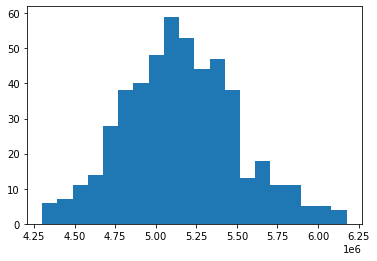

In [11]:
plt.hist(scores, bins=20)
plt.show()

In [12]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

9 variables were found.


,name,method,min,max,log,left,right,choices
0,hash_table_size,suggest_int,6.000,18.000,False,constexpr int hash_table_size =,"; // OPTIMIZE [6, 18]",NaN
1,K_START,suggest_float,0.040,0.200,True,constexpr double K_START =,"; // OPTIMIZE [0.04, 0.2] LOG",NaN
2,K_END,suggest_float,0.030,0.100,True,constexpr double K_END =,"; // OPTIMIZE [0.03, 0.1] LOG",NaN
3,K_H,suggest_float,0.001,0.999,False,constexpr double K_H =,"; // OPTIMIZE [0.001, 0.999]",NaN
4,PURCHASE_TURN_LIMIT,suggest_int,790.000,870.000,False,constexpr short PURCHASE_TURN_LIMIT =,"; // OPTIMIZE [790, 870]",NaN
5,ROUGH_HASH,suggest_categorical,NaN,NaN,NaN,constexpr int ROUGH_HASH =,"; // OPTIMIZE {0, 0b00000001, 0b00010001,...","[0, 0b00000001, 0b00010001, 0b00010011, 0b0011..."
6,TARGET_BEAM_WIDTH_INCREASE_RATE,suggest_float,0.250,4.000,True,constexpr double TARGET_BEAM_WIDTH_INCREASE_RA...,"; // OPTIMIZE [0.25, 4.0] LOG",NaN
7,TARGET_BEAM_WIDTH_HALF_PROGRES_RATE,suggest_float,0.020,0.980,False,constexpr double TARGET_BEAM_WIDTH_HALF_PROGRE...,"; // OPTIMIZE [0.02, 0.98]",NaN
8,MAX_BEAM_WIDTH,suggest_int,400.000,4000.000,True,constexpr auto MAX_BEAM_WIDTH =,"; // OPTIMIZE [400, 400...",NaN


In [24]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 12  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    #directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out 2> /dev/null
    !mkdir {index_parallel}_score 2> /dev/null
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    #command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"./{parameters_changed_filename}.out < {TESTCASE_DIRECTORY}@ >./{index_parallel}_out/@ 2> /dev/null;"
        f"python3 ../A/tester/judge.py {TESTCASE_DIRECTORY}@ ./{index_parallel}_out/@ > ./{index_parallel}_score/@"
        
        #f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {TESTCASE_DIRECTORY}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read().split(":")[-1])
    return sum_score

In [26]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 12
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=6)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=5, callbacks=[callback])

[I 2021-09-11 13:36:51,378] A new study created in RDB with name: study


index_parallel=1
index_parallel=3
index_parallel=0
index_parallel=2
index_parallel=4


/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


rm: cannot remove '1_out/*': No such file or directory
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '2_out/*': No such file or directory
rm: cannot remove '4_out/*': No such file or directory
rm: cannot remove '0_out/*': No such file or directory
rm: cannot remove '1_score/*': No such file or directory
rm: cannot remove '3_score/*': No such file or directory
rm: cannot remove '2_score/*': No such file or directory
rm: cannot remove '0_score/*': No such file or directory
rm: cannot remove '4_score/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13416582930357568;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05016246977656931;   \/\

g++ 4_main.cpp -std=gnu++17 -O2 -o 4_main.cpp.out 2> /dev/null
g++ 2_main.cpp -std=gnu++17 -O2 -o 2_main.cpp.out 2> /dev/null
g++ 0_main.cpp -std=gnu++17 -O2 -o 0_main.cpp.out 2> /dev/null


[I 2021-09-11 13:38:16,370] Trial 2 finished with value: 2337228501.0 and parameters: {'hash_table_size': 6, 'K_START': 0.12901151918594464, 'K_END': 0.08538737777579115, 'K_H': 0.2070540081632988, 'PURCHASE_TURN_LIMIT': 806, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.44851203576906745, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.024460732471798217, 'MAX_BEAM_WIDTH': 603}. Best is trial 2 with value: 2337228501.0.


Updated! 2337228501.0
callback ok
index_parallel=5
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '5_score/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16648109077919065;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05046911382693697;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6828570432443508;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 852;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b0000

[I 2021-09-11 13:38:36,409] Trial 1 finished with value: 2410925254.0 and parameters: {'hash_table_size': 6, 'K_START': 0.10859058917903176, 'K_END': 0.08445245865649212, 'K_H': 0.5948233900348715, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.3669764222974813, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.27605662023930205, 'MAX_BEAM_WIDTH': 2161}. Best is trial 1 with value: 2410925254.0.


Updated! 2410925254.0
callback ok
index_parallel=6
rm: cannot remove '6_out/*': No such file or directory
rm: cannot remove '6_score/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16820490360800505;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.037295756059961806;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2547538538375127;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 821;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b000

[I 2021-09-11 13:40:54,375] Trial 6 finished with value: 2447848052.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16820490360800505, 'K_END': 0.037295756059961806, 'K_H': 0.2547538538375127, 'PURCHASE_TURN_LIMIT': 821, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2526313131066016, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7827494218562648, 'MAX_BEAM_WIDTH': 525}. Best is trial 6 with value: 2447848052.0.


Updated! 2447848052.0
callback ok
index_parallel=7
rm: cannot remove '7_out/*': No such file or directory
rm: cannot remove '7_score/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1678016392063049;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.034286179075006855;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6814849425745764;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b000

[I 2021-09-11 13:41:56,104] Trial 3 finished with value: 2460618143.0 and parameters: {'hash_table_size': 9, 'K_START': 0.13416582930357568, 'K_END': 0.05016246977656931, 'K_H': 0.8175841869835615, 'PURCHASE_TURN_LIMIT': 791, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5808507780720698, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.04658373782342132, 'MAX_BEAM_WIDTH': 1748}. Best is trial 3 with value: 2460618143.0.


Updated! 2460618143.0
callback ok
index_parallel=8
rm: cannot remove '8_out/*': No such file or directory
rm: cannot remove '8_score/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.046480556354358944;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.08633558644468219;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35457206290055693;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 797;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b0

[I 2021-09-11 13:42:13,088] Trial 4 finished with value: 2486546297.0 and parameters: {'hash_table_size': 12, 'K_START': 0.14892135695645567, 'K_END': 0.04692022688124217, 'K_H': 0.19085678945475512, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7413277301325024, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.12317771464715342, 'MAX_BEAM_WIDTH': 3029}. Best is trial 4 with value: 2486546297.0.


Updated! 2486546297.0
callback ok
index_parallel=9
rm: cannot remove '9_out/*': No such file or directory
rm: cannot remove '9_score/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05565433802822493;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05507133809729035;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.15136041540315334;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 864;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00

[I 2021-09-11 13:42:15,450] Trial 0 finished with value: 2458195194.0 and parameters: {'hash_table_size': 18, 'K_START': 0.07740044121781983, 'K_END': 0.04672877795909802, 'K_H': 0.3540308115651504, 'PURCHASE_TURN_LIMIT': 820, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0802199058556399, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.28948552973836117, 'MAX_BEAM_WIDTH': 2017}. Best is trial 4 with value: 2486546297.0.


callback ok
index_parallel=10
rm: cannot remove '10_out/*': No such file or directory
rm: cannot remove '10_score/*': No such file or directory
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08776378778652333;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.045249719358808935;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3951887749377645;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001

[I 2021-09-11 13:42:34,567] Trial 5 finished with value: 2554896315.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16648109077919065, 'K_END': 0.05046911382693697, 'K_H': 0.6828570432443508, 'PURCHASE_TURN_LIMIT': 852, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8453716844316688, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.46492385188115426, 'MAX_BEAM_WIDTH': 689}. Best is trial 5 with value: 2554896315.0.


Updated! 2554896315.0
callback ok
index_parallel=11
rm: cannot remove '11_out/*': No such file or directory
rm: cannot remove '11_score/*': No such file or directory
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1929806499405583;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053909143247845605;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.08930204929419103;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0

[I 2021-09-11 13:45:18,321] Trial 11 finished with value: 2416260104.0 and parameters: {'hash_table_size': 7, 'K_START': 0.1929806499405583, 'K_END': 0.053909143247845605, 'K_H': 0.08930204929419103, 'PURCHASE_TURN_LIMIT': 848, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.3249852614964634, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.2286735111262734, 'MAX_BEAM_WIDTH': 3164}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 16;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04846617783509053;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.031071293599514077;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7713696553582114;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 811;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 13:46:22,222] Trial 7 finished with value: 2517867275.0 and parameters: {'hash_table_size': 17, 'K_START': 0.1678016392063049, 'K_END': 0.034286179075006855, 'K_H': 0.6814849425745764, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1400474700987924, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5801836011153916, 'MAX_BEAM_WIDTH': 1071}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04200191191856688;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06780871914440799;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4430220082467376;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 13:47:19,569] Trial 8 finished with value: 2450424985.0 and parameters: {'hash_table_size': 16, 'K_START': 0.046480556354358944, 'K_END': 0.08633558644468219, 'K_H': 0.35457206290055693, 'PURCHASE_TURN_LIMIT': 797, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.56872098209193, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5571650149393936, 'MAX_BEAM_WIDTH': 500}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07602775360891662;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06496890430237433;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9979561685396229;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 868;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 13:47:40,496] Trial 9 finished with value: 2467694379.0 and parameters: {'hash_table_size': 14, 'K_START': 0.05565433802822493, 'K_END': 0.05507133809729035, 'K_H': 0.15136041540315334, 'PURCHASE_TURN_LIMIT': 864, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1626883021836303, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8810692276703781, 'MAX_BEAM_WIDTH': 1073}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09079851564961362;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03108439795279348;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7643809597702157;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 851;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 13:47:43,067] Trial 10 finished with value: 2483152748.0 and parameters: {'hash_table_size': 16, 'K_START': 0.08776378778652333, 'K_END': 0.045249719358808935, 'K_H': 0.3951887749377645, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5652109634904102, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.09399232263521039, 'MAX_BEAM_WIDTH': 3045}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19342979295648796;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.033716317188790035;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6994730206428114;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 13:50:26,430] Trial 12 finished with value: 2425858534.0 and parameters: {'hash_table_size': 16, 'K_START': 0.04846617783509053, 'K_END': 0.031071293599514077, 'K_H': 0.7713696553582114, 'PURCHASE_TURN_LIMIT': 811, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1568489232971895, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3494739266983329, 'MAX_BEAM_WIDTH': 563}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19751847739746758;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06761863580368584;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9980335661231345;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 13:51:47,411] Trial 13 finished with value: 2470155062.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04200191191856688, 'K_END': 0.06780871914440799, 'K_H': 0.4430220082467376, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.48869484454918877, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.02253143527007335, 'MAX_BEAM_WIDTH': 984}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19975623169436468;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.031671338916298516;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6507555327360847;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 858;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 13:52:50,238] Trial 14 finished with value: 2474087880.0 and parameters: {'hash_table_size': 11, 'K_START': 0.07602775360891662, 'K_END': 0.06496890430237433, 'K_H': 0.9979561685396229, 'PURCHASE_TURN_LIMIT': 868, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.202182112283857, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8926920610809764, 'MAX_BEAM_WIDTH': 844}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.19044517992663743;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03028809098119934;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6614608334093468;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 853;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 13:53:08,803] Trial 15 finished with value: 2502350683.0 and parameters: {'hash_table_size': 11, 'K_START': 0.09079851564961362, 'K_END': 0.03108439795279348, 'K_H': 0.7643809597702157, 'PURCHASE_TURN_LIMIT': 851, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9821325612463805, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5412202970905369, 'MAX_BEAM_WIDTH': 902}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18733029791356068;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03891619199214504;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5955386365737042;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 855;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 13:53:13,303] Trial 16 finished with value: 2516511992.0 and parameters: {'hash_table_size': 11, 'K_START': 0.19342979295648796, 'K_END': 0.033716317188790035, 'K_H': 0.6994730206428114, 'PURCHASE_TURN_LIMIT': 858, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.434910290111564, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5463991091503604, 'MAX_BEAM_WIDTH': 851}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11964165271553516;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03921892118957019;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5861220238642637;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 13:55:55,477] Trial 17 finished with value: 2517624753.0 and parameters: {'hash_table_size': 10, 'K_START': 0.19751847739746758, 'K_END': 0.06761863580368584, 'K_H': 0.9980335661231345, 'PURCHASE_TURN_LIMIT': 858, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2415260736278753, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5874827411832905, 'MAX_BEAM_WIDTH': 924}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 14;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11888732883542055;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.039826548182390537;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5690803354137245;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0

[I 2021-09-11 13:57:16,570] Trial 18 finished with value: 2514816202.0 and parameters: {'hash_table_size': 12, 'K_START': 0.19975623169436468, 'K_END': 0.031671338916298516, 'K_H': 0.6507555327360847, 'PURCHASE_TURN_LIMIT': 858, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7863094430689137, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5305104788283171, 'MAX_BEAM_WIDTH': 821}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11187137800353729;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03800799462706413;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5482989145004329;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 824;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-11 13:58:18,673] Trial 19 finished with value: 2515775175.0 and parameters: {'hash_table_size': 14, 'K_START': 0.19044517992663743, 'K_END': 0.03028809098119934, 'K_H': 0.6614608334093468, 'PURCHASE_TURN_LIMIT': 853, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.8708119825987946, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5636251033930705, 'MAX_BEAM_WIDTH': 760}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 18;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11491118459115977;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.040208588779977746;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5496720823740653;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 821;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 13:58:38,122] Trial 20 finished with value: 2507282979.0 and parameters: {'hash_table_size': 14, 'K_START': 0.18733029791356068, 'K_END': 0.03891619199214504, 'K_H': 0.5955386365737042, 'PURCHASE_TURN_LIMIT': 855, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6804497740742643, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6691124227140681, 'MAX_BEAM_WIDTH': 1437}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13936573006567626;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06774960938678369;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9290003284885541;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 13:58:42,621] Trial 21 finished with value: 2522738300.0 and parameters: {'hash_table_size': 14, 'K_START': 0.11964165271553516, 'K_END': 0.03921892118957019, 'K_H': 0.5861220238642637, 'PURCHASE_TURN_LIMIT': 848, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7109606773423423, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6896698276401182, 'MAX_BEAM_WIDTH': 1462}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11660736161824753;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03982000469461256;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5073881318527202;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 14:01:22,428] Trial 22 finished with value: 2532855791.0 and parameters: {'hash_table_size': 14, 'K_START': 0.11888732883542055, 'K_END': 0.039826548182390537, 'K_H': 0.5690803354137245, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.670839391212277, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6740837467772776, 'MAX_BEAM_WIDTH': 1373}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.11465727577052863;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04041459164865729;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5184678272748175;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 14:02:43,501] Trial 23 finished with value: 2512678989.0 and parameters: {'hash_table_size': 18, 'K_START': 0.11187137800353729, 'K_END': 0.03800799462706413, 'K_H': 0.5482989145004329, 'PURCHASE_TURN_LIMIT': 824, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5716558686368591, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6840499231038901, 'MAX_BEAM_WIDTH': 1365}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1130030375472871;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04183141225837629;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4881228316516552;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:03:58,468] Trial 25 finished with value: 2545153915.0 and parameters: {'hash_table_size': 9, 'K_START': 0.13936573006567626, 'K_END': 0.06774960938678369, 'K_H': 0.9290003284885541, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.606460262991655, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41620897794121975, 'MAX_BEAM_WIDTH': 416}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14692083588133228;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06076805595789326;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8652180300972785;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:04:00,421] Trial 24 finished with value: 2491840972.0 and parameters: {'hash_table_size': 18, 'K_START': 0.11491118459115977, 'K_END': 0.040208588779977746, 'K_H': 0.5496720823740653, 'PURCHASE_TURN_LIMIT': 821, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.672979626538461, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4249204270844622, 'MAX_BEAM_WIDTH': 1303}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14859079412090892;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06043614007886569;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8778739291440917;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:04:10,185] Trial 26 finished with value: 2522604133.0 and parameters: {'hash_table_size': 15, 'K_START': 0.11660736161824753, 'K_END': 0.03982000469461256, 'K_H': 0.5073881318527202, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3044855116527554, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.698351803215614, 'MAX_BEAM_WIDTH': 1355}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15026828828730823;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06116744510863606;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8291593404265977;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:07:03,301] Trial 27 finished with value: 2515468654.0 and parameters: {'hash_table_size': 13, 'K_START': 0.11465727577052863, 'K_END': 0.04041459164865729, 'K_H': 0.5184678272748175, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.4889879721687398, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.41853004673594413, 'MAX_BEAM_WIDTH': 1392}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14754426745562763;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05959407554656947;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9054799795140227;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:08:00,015] Trial 29 finished with value: 2534710206.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14692083588133228, 'K_END': 0.06076805595789326, 'K_H': 0.8652180300972785, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6799591616987977, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4214618908245542, 'MAX_BEAM_WIDTH': 440}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15078105576080192;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07536438669641639;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9411032294062633;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:08:07,565] Trial 31 finished with value: 2523338084.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15026828828730823, 'K_END': 0.06116744510863606, 'K_H': 0.8291593404265977, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.270868198579261, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.40802619602473, 'MAX_BEAM_WIDTH': 406}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09817096763032723;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07457812403531813;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9033224111039232;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 14:08:09,819] Trial 30 finished with value: 2549001788.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14859079412090892, 'K_END': 0.06043614007886569, 'K_H': 0.8778739291440917, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.7789310271896333, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4478483775195061, 'MAX_BEAM_WIDTH': 418}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15049037096472248;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07556476994229272;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9094601445131819;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 14:08:13,042] Trial 28 finished with value: 2534422696.0 and parameters: {'hash_table_size': 13, 'K_START': 0.1130030375472871, 'K_END': 0.04183141225837629, 'K_H': 0.4881228316516552, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.226296828103247, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4333828460652944, 'MAX_BEAM_WIDTH': 419}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14926803945790454;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0750325612435459;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9045726149741209;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 14:11:07,219] Trial 32 finished with value: 2549989305.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14754426745562763, 'K_END': 0.05959407554656947, 'K_H': 0.9054799795140227, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6200633317905333, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4341195553610038, 'MAX_BEAM_WIDTH': 420}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16970783287773508;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07913073006349723;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9099499998609736;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:11:55,784] Trial 33 finished with value: 2524204299.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15078105576080192, 'K_END': 0.07536438669641639, 'K_H': 0.9411032294062633, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.785323558265573, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4288262179885655, 'MAX_BEAM_WIDTH': 401}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=2


[I 2021-09-11 14:11:55,883] Trial 34 finished with value: 2508865762.0 and parameters: {'hash_table_size': 8, 'K_START': 0.09817096763032723, 'K_END': 0.07457812403531813, 'K_H': 0.9033224111039232, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6773751913838875, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.19698427698812618, 'MAX_BEAM_WIDTH': 405}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=3
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 6;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13112710388027776;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09566908005357674;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9129130143716708;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 811;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:12:02,093] Trial 36 finished with value: 2507737861.0 and parameters: {'hash_table_size': 8, 'K_START': 0.14926803945790454, 'K_END': 0.0750325612435459, 'K_H': 0.9045726149741209, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.6315201140563484, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.31920736204000266, 'MAX_BEAM_WIDTH': 638}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 6;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.13277779569297687;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09883776603033177;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7594909482291009;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 815;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:12:12,401] Trial 35 finished with value: 2548709127.0 and parameters: {'hash_table_size': 8, 'K_START': 0.15049037096472248, 'K_END': 0.07556476994229272, 'K_H': 0.9094601445131819, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.628902293510322, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.461749345909863, 'MAX_BEAM_WIDTH': 445}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 6;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16931497090547587;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.09488918442366509;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7545136762693198;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 813;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:13:20,211] Trial 38 finished with value: 2340285766.0 and parameters: {'hash_table_size': 6, 'K_START': 0.13112710388027776, 'K_END': 0.09566908005357674, 'K_H': 0.9129130143716708, 'PURCHASE_TURN_LIMIT': 811, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9120151239797418, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.31996962625488445, 'MAX_BEAM_WIDTH': 654}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=6


[I 2021-09-11 14:13:21,496] Trial 39 finished with value: 2384211226.0 and parameters: {'hash_table_size': 6, 'K_START': 0.13310454666331487, 'K_END': 0.05518785816597476, 'K_H': 0.9225080180651853, 'PURCHASE_TURN_LIMIT': 817, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.95669141549152, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3241200851832273, 'MAX_BEAM_WIDTH': 659}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=7
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.16954756611644553;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052292888942220894;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7388309531566197;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 14:13:27,457] Trial 40 finished with value: 2354466345.0 and parameters: {'hash_table_size': 6, 'K_START': 0.13277779569297687, 'K_END': 0.09883776603033177, 'K_H': 0.7594909482291009, 'PURCHASE_TURN_LIMIT': 815, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0071308588775656, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.494097129300285, 'MAX_BEAM_WIDTH': 691}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1635143418176866;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049534982186172506;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8279207752903897;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:13:38,255] Trial 41 finished with value: 2354513192.0 and parameters: {'hash_table_size': 6, 'K_START': 0.16931497090547587, 'K_END': 0.09488918442366509, 'K_H': 0.7545136762693198, 'PURCHASE_TURN_LIMIT': 813, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9130411361811708, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4850965087377759, 'MAX_BEAM_WIDTH': 690}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1671044770036418;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05163425321903419;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8421591809696238;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 14:14:44,377] Trial 37 finished with value: 2475924436.0 and parameters: {'hash_table_size': 8, 'K_START': 0.16970783287773508, 'K_END': 0.07913073006349723, 'K_H': 0.9099499998609736, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.706026340493597, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.31697002392752066, 'MAX_BEAM_WIDTH': 663}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1575808731981883;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.049733565869002315;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8095104893140156;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 14:15:39,923] Trial 42 finished with value: 2483619669.0 and parameters: {'hash_table_size': 7, 'K_START': 0.16954756611644553, 'K_END': 0.052292888942220894, 'K_H': 0.7388309531566197, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0797984230056583, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4771358619919681, 'MAX_BEAM_WIDTH': 484}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15778535279153105;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.048915924587013146;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.832348017715525;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 849;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 14:15:41,866] Trial 43 finished with value: 2480296329.0 and parameters: {'hash_table_size': 7, 'K_START': 0.17035293189437614, 'K_END': 0.04847089455342107, 'K_H': 0.7892686829598413, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9786975409279202, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.612222328020747, 'MAX_BEAM_WIDTH': 504}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.14029268859613916;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05777849842399432;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8380247620715198;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 848;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:18:39,624] Trial 45 finished with value: 2517811729.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1671044770036418, 'K_END': 0.05163425321903419, 'K_H': 0.8421591809696238, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0398292553456487, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.25584195654330366, 'MAX_BEAM_WIDTH': 490}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10224697390551489;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05914730221700956;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9674514551639545;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:18:57,956] Trial 44 finished with value: 2552674871.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1635143418176866, 'K_END': 0.049534982186172506, 'K_H': 0.8279207752903897, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.134383378341652, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.48917494980250287, 'MAX_BEAM_WIDTH': 484}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.15870543792593333;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04457914984444999;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8613408408921263;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 803;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 14:19:51,182] Trial 46 finished with value: 2534089990.0 and parameters: {'hash_table_size': 9, 'K_START': 0.1575808731981883, 'K_END': 0.049733565869002315, 'K_H': 0.8095104893140156, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3617059965203637, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.37602122807661525, 'MAX_BEAM_WIDTH': 480}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.10243726399738912;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04423507319431001;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8527971790674398;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 804;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 14:20:48,685] Trial 47 finished with value: 2508377730.0 and parameters: {'hash_table_size': 9, 'K_START': 0.15778535279153105, 'K_END': 0.048915924587013146, 'K_H': 0.832348017715525, 'PURCHASE_TURN_LIMIT': 849, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.383187200740624, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.37550705813676133, 'MAX_BEAM_WIDTH': 487}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=4


[I 2021-09-11 14:20:49,108] Trial 48 finished with value: 2531150512.0 and parameters: {'hash_table_size': 9, 'K_START': 0.14029268859613916, 'K_END': 0.05777849842399432, 'K_H': 0.8380247620715198, 'PURCHASE_TURN_LIMIT': 848, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.292600336895543, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.2555679207388625, 'MAX_BEAM_WIDTH': 558}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=5
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07964944743319141;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.044841916963893544;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9639223491119322;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 826;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 14:24:00,743] Trial 50 finished with value: 2467623378.0 and parameters: {'hash_table_size': 10, 'K_START': 0.15870543792593333, 'K_END': 0.04457914984444999, 'K_H': 0.8613408408921263, 'PURCHASE_TURN_LIMIT': 803, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.3196827968294302, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.37511044315606373, 'MAX_BEAM_WIDTH': 556}. Best is trial 5 with value: 2554896315.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09998665498063117;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06259161774957868;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9637230917297522;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 14:24:06,745] Trial 49 finished with value: 2561768169.0 and parameters: {'hash_table_size': 9, 'K_START': 0.10224697390551489, 'K_END': 0.05914730221700956, 'K_H': 0.9674514551639545, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.382913370009112, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.622771585501461, 'MAX_BEAM_WIDTH': 557}. Best is trial 49 with value: 2561768169.0.


Updated! 2561768169.0
callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0688546283717342;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05798944058328245;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9688877406698728;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00

[I 2021-09-11 14:24:48,741] Trial 51 finished with value: 2468949241.0 and parameters: {'hash_table_size': 10, 'K_START': 0.10243726399738912, 'K_END': 0.04423507319431001, 'K_H': 0.8527971790674398, 'PURCHASE_TURN_LIMIT': 804, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.5097979027997965, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.3714969792854429, 'MAX_BEAM_WIDTH': 553}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07220206273568068;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057894943061740735;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9729388151326268;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 14:26:16,040] Trial 53 finished with value: 2512790731.0 and parameters: {'hash_table_size': 10, 'K_START': 0.0672147651671899, 'K_END': 0.044995534540106276, 'K_H': 0.7129889463958813, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.2507590964584256, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6111771531736394, 'MAX_BEAM_WIDTH': 562}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18151861985127593;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05824920795277525;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9694318294041135;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:26:20,432] Trial 52 finished with value: 2445730775.0 and parameters: {'hash_table_size': 10, 'K_START': 0.07964944743319141, 'K_END': 0.044841916963893544, 'K_H': 0.9639223491119322, 'PURCHASE_TURN_LIMIT': 826, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.2606748107145703, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6310770652902117, 'MAX_BEAM_WIDTH': 2142}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18238596376302937;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05911324213188842;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9639563957811734;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 14:27:32,297] Trial 56 finished with value: 2504825304.0 and parameters: {'hash_table_size': 7, 'K_START': 0.07220206273568068, 'K_END': 0.057894943061740735, 'K_H': 0.9729388151326268, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.26248193840710976, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6208858297465897, 'MAX_BEAM_WIDTH': 2409}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.18137005665842312;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06315842395096713;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8786728293463238;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 14:28:50,054] Trial 58 finished with value: 2509685924.0 and parameters: {'hash_table_size': 7, 'K_START': 0.18238596376302937, 'K_END': 0.05911324213188842, 'K_H': 0.9639563957811734, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4523494960609034, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7388031616771825, 'MAX_BEAM_WIDTH': 456}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12511446068558105;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06523570940218414;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8742195148770578;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 864;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:28:55,925] Trial 57 finished with value: 2517113161.0 and parameters: {'hash_table_size': 7, 'K_START': 0.18151861985127593, 'K_END': 0.05824920795277525, 'K_H': 0.9694318294041135, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.4065638755151095, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5103336175101285, 'MAX_BEAM_WIDTH': 2092}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.12605390958116436;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06500982427663804;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.02639080844434355;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 863;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 14:29:28,390] Trial 54 finished with value: 2541829109.0 and parameters: {'hash_table_size': 10, 'K_START': 0.09998665498063117, 'K_END': 0.06259161774957868, 'K_H': 0.9637230917297522, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.47900990486783, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.971723178227792, 'MAX_BEAM_WIDTH': 1878}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.1241843631978257;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054245911191873115;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6251930138702281;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 862;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 14:29:34,036] Trial 55 finished with value: 2556076101.0 and parameters: {'hash_table_size': 10, 'K_START': 0.0688546283717342, 'K_END': 0.05798944058328245, 'K_H': 0.9688877406698728, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.4779713852640133, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7991387123107914, 'MAX_BEAM_WIDTH': 575}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06061316681880651;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06485645564681827;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8832117342914964;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 819;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 14:30:28,215] Trial 59 finished with value: 2512825460.0 and parameters: {'hash_table_size': 7, 'K_START': 0.18137005665842312, 'K_END': 0.06315842395096713, 'K_H': 0.8786728293463238, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3640758081580047, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5028930627282598, 'MAX_BEAM_WIDTH': 3925}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 11;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.056104850781651484;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055006622931995826;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2723852707394371;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 863;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 14:31:19,714] Trial 60 finished with value: 2474520612.0 and parameters: {'hash_table_size': 7, 'K_START': 0.12511446068558105, 'K_END': 0.06523570940218414, 'K_H': 0.8742195148770578, 'PURCHASE_TURN_LIMIT': 864, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3983645724476232, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5133149490118822, 'MAX_BEAM_WIDTH': 600}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05911133646411857;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05422075050431372;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7943939942921612;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:34:33,814] Trial 61 finished with value: 2440355895.0 and parameters: {'hash_table_size': 11, 'K_START': 0.12605390958116436, 'K_END': 0.06500982427663804, 'K_H': 0.02639080844434355, 'PURCHASE_TURN_LIMIT': 863, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0042721247751807, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4773841894692167, 'MAX_BEAM_WIDTH': 608}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.059705225802318386;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05547690525492757;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6246709033205187;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 14:35:00,503] Trial 63 finished with value: 2535178925.0 and parameters: {'hash_table_size': 11, 'K_START': 0.06061316681880651, 'K_END': 0.06485645564681827, 'K_H': 0.8832117342914964, 'PURCHASE_TURN_LIMIT': 819, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0170106887481452, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7618716985903863, 'MAX_BEAM_WIDTH': 606}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08339248023172668;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0544603596329436;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7922798796769275;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 822;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 14:35:10,102] Trial 62 finished with value: 2488270336.0 and parameters: {'hash_table_size': 11, 'K_START': 0.1241843631978257, 'K_END': 0.054245911191873115, 'K_H': 0.6251930138702281, 'PURCHASE_TURN_LIMIT': 862, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9584932761074708, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4596355520964418, 'MAX_BEAM_WIDTH': 1136}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05359263784749533;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.055722449474837045;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.9952879141245827;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 14:35:58,022] Trial 64 finished with value: 2507892371.0 and parameters: {'hash_table_size': 11, 'K_START': 0.056104850781651484, 'K_END': 0.055006622931995826, 'K_H': 0.2723852707394371, 'PURCHASE_TURN_LIMIT': 863, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.00322385756437, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8337910165538719, 'MAX_BEAM_WIDTH': 774}. Best is trial 49 with value: 2561768169.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09144650763137567;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05155107964143808;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.8002048838550692;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 855;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 14:36:51,912] Trial 65 finished with value: 2562684736.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05911133646411857, 'K_END': 0.05422075050431372, 'K_H': 0.7943939942921612, 'PURCHASE_TURN_LIMIT': 820, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.8987032807432382, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.4581923445870931, 'MAX_BEAM_WIDTH': 746}. Best is trial 65 with value: 2562684736.0.


Updated! 2562684736.0
callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047002913554271886;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04710492297163081;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7887735347675472;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 822;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0

[I 2021-09-11 14:39:56,029] Trial 66 finished with value: 2553242844.0 and parameters: {'hash_table_size': 9, 'K_START': 0.059705225802318386, 'K_END': 0.05547690525492757, 'K_H': 0.6246709033205187, 'PURCHASE_TURN_LIMIT': 820, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.0618565914290232, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8181116585467144, 'MAX_BEAM_WIDTH': 453}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04805180641759722;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047263273795099224;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6784467104291314;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 822;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 14:40:30,400] Trial 67 finished with value: 2555635216.0 and parameters: {'hash_table_size': 9, 'K_START': 0.08339248023172668, 'K_END': 0.0544603596329436, 'K_H': 0.7922798796769275, 'PURCHASE_TURN_LIMIT': 822, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.018841737821452, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.45591565581006993, 'MAX_BEAM_WIDTH': 452}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06252834185265661;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0471431245491084;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6796160632881486;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 817;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 14:40:33,027] Trial 68 finished with value: 2550179586.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05359263784749533, 'K_END': 0.055722449474837045, 'K_H': 0.9952879141245827, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.98274791278384, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.793676894133249, 'MAX_BEAM_WIDTH': 447}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06340606597587212;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052288058997250274;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6823848184840792;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 821;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 14:41:23,949] Trial 69 finished with value: 2537403554.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09144650763137567, 'K_END': 0.05155107964143808, 'K_H': 0.8002048838550692, 'PURCHASE_TURN_LIMIT': 855, 'ROUGH_HASH': '0b00010001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.9974723585085576, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5749726092884859, 'MAX_BEAM_WIDTH': 455}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 12;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06639127546999814;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.047148960156636104;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6812776556710429;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 820;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 14:42:17,850] Trial 70 finished with value: 2542424072.0 and parameters: {'hash_table_size': 9, 'K_START': 0.047002913554271886, 'K_END': 0.04710492297163081, 'K_H': 0.7887735347675472, 'PURCHASE_TURN_LIMIT': 822, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.9116800020456814, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8380655504128901, 'MAX_BEAM_WIDTH': 738}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.050604197675047626;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0563607888651429;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6674897567343789;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 819;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:45:21,703] Trial 71 finished with value: 2547585475.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04805180641759722, 'K_END': 0.047263273795099224, 'K_H': 0.6784467104291314, 'PURCHASE_TURN_LIMIT': 822, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.981685349006229, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8252145871744161, 'MAX_BEAM_WIDTH': 741}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05366765884345761;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05646224661596014;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7258470273946156;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 817;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:45:56,146] Trial 72 finished with value: 2547488751.0 and parameters: {'hash_table_size': 9, 'K_START': 0.06252834185265661, 'K_END': 0.0471431245491084, 'K_H': 0.6796160632881486, 'PURCHASE_TURN_LIMIT': 817, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.8311255217784916, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8377502110155322, 'MAX_BEAM_WIDTH': 767}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05336994749670256;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0562836761223332;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6322166814162575;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 819;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:45:58,903] Trial 73 finished with value: 2554493771.0 and parameters: {'hash_table_size': 9, 'K_START': 0.06340606597587212, 'K_END': 0.052288058997250274, 'K_H': 0.6823848184840792, 'PURCHASE_TURN_LIMIT': 821, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.7545814539343554, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8893309474342004, 'MAX_BEAM_WIDTH': 731}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07023562460822945;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05312830733899803;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6353225734433917;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 819;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 14:46:49,589] Trial 74 finished with value: 2538083483.0 and parameters: {'hash_table_size': 12, 'K_START': 0.06639127546999814, 'K_END': 0.047148960156636104, 'K_H': 0.6812776556710429, 'PURCHASE_TURN_LIMIT': 820, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.732336501490813, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8915387683856311, 'MAX_BEAM_WIDTH': 754}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08383169294623838;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.052338802800032794;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6414086328770582;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 811;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 14:47:42,966] Trial 75 finished with value: 2555138530.0 and parameters: {'hash_table_size': 9, 'K_START': 0.050604197675047626, 'K_END': 0.0563607888651429, 'K_H': 0.6674897567343789, 'PURCHASE_TURN_LIMIT': 819, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.1558675935748424, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8024517625120282, 'MAX_BEAM_WIDTH': 521}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05150479526950697;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05304583006972557;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.633855510795006;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 812;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:50:46,563] Trial 76 finished with value: 2550472581.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05366765884345761, 'K_END': 0.05646224661596014, 'K_H': 0.7258470273946156, 'PURCHASE_TURN_LIMIT': 817, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2443370645328433, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9256931623144482, 'MAX_BEAM_WIDTH': 518}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 10;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04358789831245979;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05247848969466685;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6045206662011581;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 809;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 14:51:21,719] Trial 77 finished with value: 2544794353.0 and parameters: {'hash_table_size': 10, 'K_START': 0.05336994749670256, 'K_END': 0.0562836761223332, 'K_H': 0.6322166814162575, 'PURCHASE_TURN_LIMIT': 819, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2507507978934496, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8758113867501913, 'MAX_BEAM_WIDTH': 521}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.042602701502742306;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05269987628660081;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.6140642518944374;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 810;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 14:51:24,579] Trial 78 finished with value: 2547181080.0 and parameters: {'hash_table_size': 10, 'K_START': 0.07023562460822945, 'K_END': 0.05312830733899803, 'K_H': 0.6353225734433917, 'PURCHASE_TURN_LIMIT': 819, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.2403743949295634, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.924695366586921, 'MAX_BEAM_WIDTH': 523}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.041791663088540806;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0704652493251183;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5919985543462349;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 809;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 14:52:15,195] Trial 79 finished with value: 2537806040.0 and parameters: {'hash_table_size': 10, 'K_START': 0.08383169294623838, 'K_END': 0.052338802800032794, 'K_H': 0.6414086328770582, 'PURCHASE_TURN_LIMIT': 811, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.371687665509143, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9365382980029138, 'MAX_BEAM_WIDTH': 534}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04337021022199322;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07102062659885067;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5940943694502591;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 814;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:53:08,316] Trial 80 finished with value: 2535551853.0 and parameters: {'hash_table_size': 10, 'K_START': 0.05150479526950697, 'K_END': 0.05304583006972557, 'K_H': 0.633855510795006, 'PURCHASE_TURN_LIMIT': 812, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 3.223412820480626, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9435137720474844, 'MAX_BEAM_WIDTH': 527}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05755161592290967;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0698649820344744;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.589519920093929;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 14:55:32,524] Trial 83 finished with value: 2534182702.0 and parameters: {'hash_table_size': 8, 'K_START': 0.041791663088540806, 'K_END': 0.0704652493251183, 'K_H': 0.5919985543462349, 'PURCHASE_TURN_LIMIT': 809, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.494249282569188, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7102057757993095, 'MAX_BEAM_WIDTH': 996}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05899892930270699;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05068539470767779;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.699042189331407;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 14:55:34,851] Trial 82 finished with value: 2528773228.0 and parameters: {'hash_table_size': 8, 'K_START': 0.042602701502742306, 'K_END': 0.05269987628660081, 'K_H': 0.6140642518944374, 'PURCHASE_TURN_LIMIT': 810, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.473267367744755, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7420484226234405, 'MAX_BEAM_WIDTH': 955}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05859380211249554;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05027581486591132;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4669761916344552;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:56:11,279] Trial 81 finished with value: 2530246476.0 and parameters: {'hash_table_size': 10, 'K_START': 0.04358789831245979, 'K_END': 0.05247848969466685, 'K_H': 0.6045206662011581, 'PURCHASE_TURN_LIMIT': 809, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4860208768640866, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7256982725836985, 'MAX_BEAM_WIDTH': 960}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05801502934822825;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05050803697600767;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7358014055815381;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 816;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 14:56:22,490] Trial 84 finished with value: 2542724674.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04337021022199322, 'K_END': 0.07102062659885067, 'K_H': 0.5940943694502591, 'PURCHASE_TURN_LIMIT': 814, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.4542385265839455, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7290154550987814, 'MAX_BEAM_WIDTH': 947}. Best is trial 65 with value: 2562684736.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05958323683688571;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.050267077274937816;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7287206174159467;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 14:57:22,501] Trial 85 finished with value: 2563351916.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05755161592290967, 'K_END': 0.0698649820344744, 'K_H': 0.589519920093929, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.120528943806321, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8638084818724264, 'MAX_BEAM_WIDTH': 956}. Best is trial 85 with value: 2563351916.0.


Updated! 2563351916.0
callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06038293086779739;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05068438456277573;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5385834873177613;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 816;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00

[I 2021-09-11 14:59:46,150] Trial 86 finished with value: 2561755709.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05899892930270699, 'K_END': 0.05068539470767779, 'K_H': 0.699042189331407, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.100360780561129, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7907228126907402, 'MAX_BEAM_WIDTH': 593}. Best is trial 85 with value: 2563351916.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05754724313385928;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0605896378614644;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.7060517037610338;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 14:59:53,312] Trial 87 finished with value: 2563357205.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05859380211249554, 'K_END': 0.05027581486591132, 'K_H': 0.4669761916344552, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1625209586993304, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8649648450691327, 'MAX_BEAM_WIDTH': 873}. Best is trial 87 with value: 2563357205.0.


Updated! 2563357205.0
callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.049791631967739974;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05126724905834331;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.48654484549994736;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b000

[I 2021-09-11 15:00:20,237] Trial 88 finished with value: 2539671853.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05801502934822825, 'K_END': 0.05050803697600767, 'K_H': 0.7358014055815381, 'PURCHASE_TURN_LIMIT': 816, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1514620509059306, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8068584002914512, 'MAX_BEAM_WIDTH': 592}. Best is trial 87 with value: 2563357205.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.056742097618977916;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.04259169452421748;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4681492051199167;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 15:01:34,903] Trial 90 finished with value: 2542249223.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06038293086779739, 'K_END': 0.05068438456277573, 'K_H': 0.5385834873177613, 'PURCHASE_TURN_LIMIT': 816, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.77989953766213, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8661052465216457, 'MAX_BEAM_WIDTH': 831}. Best is trial 87 with value: 2563357205.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04941325720382643;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06217657850903107;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4693959020875111;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 827;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 15:01:48,764] Trial 89 finished with value: 2549989136.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05958323683688571, 'K_END': 0.050267077274937816, 'K_H': 0.7287206174159467, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0791804433679903, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7944648340656464, 'MAX_BEAM_WIDTH': 842}. Best is trial 87 with value: 2563357205.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06436693749189537;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0570224746579097;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.42214018453209273;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 823;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:04:00,458] Trial 91 finished with value: 2566603152.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05754724313385928, 'K_END': 0.0605896378614644, 'K_H': 0.7060517037610338, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.133220942687753, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6567844210548217, 'MAX_BEAM_WIDTH': 823}. Best is trial 91 with value: 2566603152.0.


Updated! 2566603152.0
callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05016117076520568;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.042917000026429404;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.47819682255479035;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b

[I 2021-09-11 15:04:05,052] Trial 92 finished with value: 2559311161.0 and parameters: {'hash_table_size': 8, 'K_START': 0.049791631967739974, 'K_END': 0.05126724905834331, 'K_H': 0.48654484549994736, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1376233088890024, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7931187495766724, 'MAX_BEAM_WIDTH': 858}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05023878501832441;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06185390430253399;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4591394694572358;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:04:31,030] Trial 93 finished with value: 2549724447.0 and parameters: {'hash_table_size': 8, 'K_START': 0.056742097618977916, 'K_END': 0.04259169452421748, 'K_H': 0.4681492051199167, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8795822770315902, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8627355374899588, 'MAX_BEAM_WIDTH': 801}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05179417633017757;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06197795050248194;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.47854417369156865;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:05:45,248] Trial 94 finished with value: 2556753624.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04941325720382643, 'K_END': 0.06217657850903107, 'K_H': 0.4693959020875111, 'PURCHASE_TURN_LIMIT': 827, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.0733236397410257, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7792380765913979, 'MAX_BEAM_WIDTH': 1071}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.050553161744266634;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.062321269408227756;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.38511538210586327;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-11 15:06:00,857] Trial 95 finished with value: 2562840883.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06436693749189537, 'K_END': 0.0570224746579097, 'K_H': 0.42214018453209273, 'PURCHASE_TURN_LIMIT': 823, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7362209411105358, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7611286633086256, 'MAX_BEAM_WIDTH': 694}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04997833394123631;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06277632528345355;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.41095892956807034;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 15:08:13,878] Trial 97 finished with value: 2565816813.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05023878501832441, 'K_END': 0.06185390430253399, 'K_H': 0.4591394694572358, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8864307938069542, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.76507784401623, 'MAX_BEAM_WIDTH': 887}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05008762554139357;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061070758516773994;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.41861795945767927;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 15:08:15,561] Trial 99 finished with value: 2508020036.0 and parameters: {'hash_table_size': 7, 'K_START': 0.050553161744266634, 'K_END': 0.062321269408227756, 'K_H': 0.38511538210586327, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7584488534957625, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6613787364889108, 'MAX_BEAM_WIDTH': 1100}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06538422972369953;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05985544151121505;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.44408787500041036;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 15:08:20,303] Trial 96 finished with value: 2541273359.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05016117076520568, 'K_END': 0.042917000026429404, 'K_H': 0.47819682255479035, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.8257786430045602, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6443359914833925, 'MAX_BEAM_WIDTH': 1096}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.044721560457990965;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0606053192303684;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.45730595835420673;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 15:08:28,574] Trial 100 finished with value: 2508907993.0 and parameters: {'hash_table_size': 7, 'K_START': 0.04997833394123631, 'K_END': 0.06277632528345355, 'K_H': 0.41095892956807034, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7688452096768068, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7653043326380565, 'MAX_BEAM_WIDTH': 1076}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06368531667289101;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.060568780323128533;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4506959525995379;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00000001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 15:08:46,510] Trial 98 finished with value: 2563302573.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05179417633017757, 'K_END': 0.06197795050248194, 'K_H': 0.47854417369156865, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.722929986664991, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6535299892496246, 'MAX_BEAM_WIDTH': 887}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04498268266739941;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06041150172573467;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4470747443846629;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:10:42,531] Trial 101 finished with value: 2507918296.0 and parameters: {'hash_table_size': 7, 'K_START': 0.05008762554139357, 'K_END': 0.061070758516773994, 'K_H': 0.41861795945767927, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.7625007843352682, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7604664064163071, 'MAX_BEAM_WIDTH': 1120}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04514729973191293;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07063117781039753;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4585608134266308;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:10:45,456] Trial 103 finished with value: 2502425121.0 and parameters: {'hash_table_size': 7, 'K_START': 0.044721560457990965, 'K_END': 0.0606053192303684, 'K_H': 0.45730595835420673, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5723460072563995, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.761874530162613, 'MAX_BEAM_WIDTH': 876}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04564043246280245;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06778017462141729;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.43783318260498383;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 15:12:24,710] Trial 102 finished with value: 2564522717.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06538422972369953, 'K_END': 0.05985544151121505, 'K_H': 0.44408787500041036, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1899980647375, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7593970140736803, 'MAX_BEAM_WIDTH': 901}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06438638572356795;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06811593016718895;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.33889035099906406;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:12:40,588] Trial 104 finished with value: 2563536438.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06368531667289101, 'K_END': 0.060568780323128533, 'K_H': 0.4506959525995379, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00000001', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1488802402192184, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7745800606898032, 'MAX_BEAM_WIDTH': 865}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06398850056263432;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06892729795556979;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35718842820837093;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:12:59,526] Trial 105 finished with value: 2560815936.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04498268266739941, 'K_END': 0.06041150172573467, 'K_H': 0.4470747443846629, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1257892719417404, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7609471481050352, 'MAX_BEAM_WIDTH': 885}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06368175617853879;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06661359184928599;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3296163731996627;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:14:59,789] Trial 106 finished with value: 2565671087.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04514729973191293, 'K_END': 0.07063117781039753, 'K_H': 0.4585608134266308, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5063589348915685, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6931202201990339, 'MAX_BEAM_WIDTH': 893}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=3


[I 2021-09-11 15:15:01,165] Trial 107 finished with value: 2559501792.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04564043246280245, 'K_END': 0.06778017462141729, 'K_H': 0.43783318260498383, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.139545726174999, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.694350587315832, 'MAX_BEAM_WIDTH': 1007}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=4
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040570789119348916;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06661092912763267;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.32008663835857526;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:16:40,723] Trial 108 finished with value: 2564807421.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06438638572356795, 'K_END': 0.06811593016718895, 'K_H': 0.33889035099906406, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.1829509035093055, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8540956981402169, 'MAX_BEAM_WIDTH': 892}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 6;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06428742830106941;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06970780652586281;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3161988167554146;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:16:58,316] Trial 109 finished with value: 2564579537.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06398850056263432, 'K_END': 0.06892729795556979, 'K_H': 0.35718842820837093, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6629867065351065, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7054172052371855, 'MAX_BEAM_WIDTH': 903}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 6;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.040173940686381734;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07119322696572249;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.30873415023192013;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 15:17:17,994] Trial 110 finished with value: 2563929868.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06368175617853879, 'K_END': 0.06661359184928599, 'K_H': 0.3296163731996627, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2169769723215884, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7124896709470375, 'MAX_BEAM_WIDTH': 1187}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06506055511193932;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0703318862814607;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3340424274181177;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 841;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 15:17:25,929] Trial 111 finished with value: 2507348765.0 and parameters: {'hash_table_size': 7, 'K_START': 0.040570789119348916, 'K_END': 0.06661092912763267, 'K_H': 0.32008663835857526, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6318757826642905, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5924515625062514, 'MAX_BEAM_WIDTH': 709}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06475658086945393;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0701682242272552;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3387274432139117;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 15:17:30,885] Trial 112 finished with value: 2500062467.0 and parameters: {'hash_table_size': 7, 'K_START': 0.06495209114409838, 'K_END': 0.08138082963172541, 'K_H': 0.5090657651094096, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.2622732112387176, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6618718464297167, 'MAX_BEAM_WIDTH': 1222}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07282807780591789;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07027932112379956;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3380306068608081;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 15:18:14,888] Trial 113 finished with value: 2442155075.0 and parameters: {'hash_table_size': 6, 'K_START': 0.06428742830106941, 'K_END': 0.06970780652586281, 'K_H': 0.3161988167554146, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9521932397083621, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.5944586900089556, 'MAX_BEAM_WIDTH': 1183}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07511316981657554;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07335733613440465;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.37157271828624355;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-11 15:18:32,288] Trial 114 finished with value: 2400295262.0 and parameters: {'hash_table_size': 6, 'K_START': 0.040173940686381734, 'K_END': 0.07119322696572249, 'K_H': 0.30873415023192013, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.9645217311796497, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.704370362823023, 'MAX_BEAM_WIDTH': 1216}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07341150581485986;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07222850663439573;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35689030222174806;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 15:19:45,827] Trial 115 finished with value: 2507920384.0 and parameters: {'hash_table_size': 7, 'K_START': 0.06506055511193932, 'K_END': 0.0703318862814607, 'K_H': 0.3340424274181177, 'PURCHASE_TURN_LIMIT': 841, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.676877959488145, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7122764514566023, 'MAX_BEAM_WIDTH': 924}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07258475216991896;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07717484594798962;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3726002419650062;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 846;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:21:41,860] Trial 117 finished with value: 2519913911.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07282807780591789, 'K_END': 0.07027932112379956, 'K_H': 0.3380306068608081, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.858029449681917, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7094360178959627, 'MAX_BEAM_WIDTH': 910}. Best is trial 91 with value: 2566603152.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05502734021743616;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0642073338306747;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3769583331785406;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 15:21:43,437] Trial 116 finished with value: 2571045475.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06475658086945393, 'K_END': 0.0701682242272552, 'K_H': 0.3387274432139117, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5295910326027868, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7100792964279982, 'MAX_BEAM_WIDTH': 1220}. Best is trial 116 with value: 2571045475.0.


Updated! 2571045475.0
g++ 1_main.cpp -std=gnu++17 -O2 -o 1_main.cpp.out 2> /dev/null
callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.062140082320940156;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07335175703137141;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3902348784941016;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/cons

[I 2021-09-11 15:22:20,999] Trial 118 finished with value: 2517493391.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07511316981657554, 'K_END': 0.07335733613440465, 'K_H': 0.37157271828624355, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5081558560591162, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7064785022569118, 'MAX_BEAM_WIDTH': 1026}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06185294016679692;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.07301372178241147;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.20521432324232103;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:22:50,035] Trial 119 finished with value: 2560876246.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07341150581485986, 'K_END': 0.07222850663439573, 'K_H': 0.35689030222174806, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.6543431724969695, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7126717851201558, 'MAX_BEAM_WIDTH': 1523}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06844238927369807;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06641361750741114;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2161891415182894;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:24:06,391] Trial 120 finished with value: 2551581629.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07258475216991896, 'K_END': 0.07717484594798962, 'K_H': 0.3726002419650062, 'PURCHASE_TURN_LIMIT': 846, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5223071255853091, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6860497689798227, 'MAX_BEAM_WIDTH': 1028}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06871408214263597;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06411896293612905;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.23454687178304962;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:25:20,072] Trial 124 finished with value: 2508052268.0 and parameters: {'hash_table_size': 7, 'K_START': 0.06844238927369807, 'K_END': 0.06641361750741114, 'K_H': 0.2161891415182894, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.4795168888058507, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.6828133183761171, 'MAX_BEAM_WIDTH': 815}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06184875171136123;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06885902237088948;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4170138053475075;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:25:55,563] Trial 121 finished with value: 2568884878.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05502734021743616, 'K_END': 0.0642073338306747, 'K_H': 0.3769583331785406, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5524137995258818, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8562485455363114, 'MAX_BEAM_WIDTH': 800}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 17;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0616038804367653;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06867764343213914;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.39388180976616805;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:27:11,513] Trial 122 finished with value: 2509488865.0 and parameters: {'hash_table_size': 17, 'K_START': 0.062140082320940156, 'K_END': 0.07335175703137141, 'K_H': 0.3902348784941016, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.4573643120537754, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8496958016324995, 'MAX_BEAM_WIDTH': 1612}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05515613755590819;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06389722580144407;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2829335518927218;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:27:49,219] Trial 123 finished with value: 2509742687.0 and parameters: {'hash_table_size': 17, 'K_START': 0.06185294016679692, 'K_END': 0.07301372178241147, 'K_H': 0.20521432324232103, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2220252630510073, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8552974654912607, 'MAX_BEAM_WIDTH': 804}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05751315085050085;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06828878619884063;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5407320005829074;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:28:23,354] Trial 125 finished with value: 2568800964.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06871408214263597, 'K_END': 0.06411896293612905, 'K_H': 0.23454687178304962, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.358741969627289, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8517238261995108, 'MAX_BEAM_WIDTH': 794}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.056344209630222325;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06877786522082702;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.26649910962053147;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 839;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011

[I 2021-09-11 15:29:34,448] Trial 126 finished with value: 2563666407.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06184875171136123, 'K_END': 0.06885902237088948, 'K_H': 0.4170138053475075, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2568563468551488, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.647218777654489, 'MAX_BEAM_WIDTH': 790}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06991630022354886;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06459764755706669;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2873177355470925;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:30:52,299] Trial 130 finished with value: 2505541307.0 and parameters: {'hash_table_size': 7, 'K_START': 0.056344209630222325, 'K_END': 0.06877786522082702, 'K_H': 0.26649910962053147, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.24717395153718, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9158205626110715, 'MAX_BEAM_WIDTH': 913}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.054184390874307035;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06382200766795926;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4310051699625975;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:31:23,162] Trial 127 finished with value: 2517816186.0 and parameters: {'hash_table_size': 17, 'K_START': 0.0616038804367653, 'K_END': 0.06867764343213914, 'K_H': 0.39388180976616805, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3031295774872222, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.85147797154888, 'MAX_BEAM_WIDTH': 784}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.054298695944852794;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06576508780108391;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2857620785302669;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:31:28,518] Trial 128 finished with value: 2566464465.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05515613755590819, 'K_END': 0.06389722580144407, 'K_H': 0.2829335518927218, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 2.250946267109815, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9126785317181371, 'MAX_BEAM_WIDTH': 796}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07006539858801518;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06393568889349234;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2937511576717328;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:32:05,206] Trial 131 finished with value: 2511881711.0 and parameters: {'hash_table_size': 7, 'K_START': 0.06991630022354886, 'K_END': 0.06459764755706669, 'K_H': 0.2873177355470925, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.261897850035081, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7347834571483657, 'MAX_BEAM_WIDTH': 1307}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=3


[I 2021-09-11 15:32:06,392] Trial 129 finished with value: 2566871876.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05751315085050085, 'K_END': 0.06828878619884063, 'K_H': 0.5407320005829074, 'PURCHASE_TURN_LIMIT': 839, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2945486344798982, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9040029022993599, 'MAX_BEAM_WIDTH': 871}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=4
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05495691888074033;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06374140658356002;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2966603766219351;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:35:09,525] Trial 132 finished with value: 2567519581.0 and parameters: {'hash_table_size': 8, 'K_START': 0.054184390874307035, 'K_END': 0.06382200766795926, 'K_H': 0.4310051699625975, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2058047750181093, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9072709325203384, 'MAX_BEAM_WIDTH': 782}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05440781255833196;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06367975117438433;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.16476139459907804;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:35:44,208] Trial 133 finished with value: 2563997795.0 and parameters: {'hash_table_size': 8, 'K_START': 0.054298695944852794, 'K_END': 0.06576508780108391, 'K_H': 0.2857620785302669, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1778728512745178, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.7369671938928375, 'MAX_BEAM_WIDTH': 1300}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05423312315471977;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06362926085410013;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3517604106443394;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:35:47,813] Trial 134 finished with value: 2567719847.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07006539858801518, 'K_END': 0.06393568889349234, 'K_H': 0.2937511576717328, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.348299716345071, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9080691266337332, 'MAX_BEAM_WIDTH': 1292}. Best is trial 116 with value: 2571045475.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05423907814765856;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06391201649429686;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.29312360057692644;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:36:21,662] Trial 135 finished with value: 2571256139.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05495691888074033, 'K_END': 0.06374140658356002, 'K_H': 0.2966603766219351, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1508425942452123, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9681404026813015, 'MAX_BEAM_WIDTH': 832}. Best is trial 135 with value: 2571256139.0.


Updated! 2571256139.0
callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05266181740007578;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06397407437484709;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.22348228148373103;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b0

[I 2021-09-11 15:36:26,833] Trial 136 finished with value: 2560361555.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06691194417983615, 'K_END': 0.06407627699432547, 'K_H': 0.2353181245371478, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1564902303220301, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9674268556335988, 'MAX_BEAM_WIDTH': 839}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05579211788787492;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06405607360515364;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.16748175000363424;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:40:06,002] Trial 138 finished with value: 2565097509.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05423312315471977, 'K_END': 0.06362926085410013, 'K_H': 0.3517604106443394, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3217895998722962, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9110196134436536, 'MAX_BEAM_WIDTH': 827}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05317841444232102;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06449557054158861;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3520697471700644;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:40:37,977] Trial 137 finished with value: 2535868700.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05440781255833196, 'K_END': 0.06367975117438433, 'K_H': 0.16476139459907804, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1233442887364207, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9787492674784992, 'MAX_BEAM_WIDTH': 783}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04757271319820666;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06731197689285938;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2980715926948628;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:41:15,466] Trial 139 finished with value: 2547961288.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05423907814765856, 'K_END': 0.06391201649429686, 'K_H': 0.29312360057692644, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1038930986940996, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9601612738573779, 'MAX_BEAM_WIDTH': 837}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.052487857793365005;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06651508257676458;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2509535734784934;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:41:49,579] Trial 140 finished with value: 2538184594.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05266181740007578, 'K_END': 0.06397407437484709, 'K_H': 0.22348228148373103, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.054280701695036, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8992583942496346, 'MAX_BEAM_WIDTH': 827}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.047918373873178925;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05870180995378591;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2527184793529087;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:41:54,733] Trial 141 finished with value: 2548667820.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05579211788787492, 'K_END': 0.06405607360515364, 'K_H': 0.16748175000363424, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0942060900556907, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9059494224456381, 'MAX_BEAM_WIDTH': 662}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04707493105061884;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05933385972199572;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35448006762108186;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:43:42,466] Trial 144 finished with value: 2512760040.0 and parameters: {'hash_table_size': 7, 'K_START': 0.052487857793365005, 'K_END': 0.06651508257676458, 'K_H': 0.2509535734784934, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3459177600873486, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.908426861403681, 'MAX_BEAM_WIDTH': 651}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.04804633187833154;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059221383546862905;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.35217979363278884;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:45:34,311] Trial 142 finished with value: 2542580880.0 and parameters: {'hash_table_size': 9, 'K_START': 0.05317841444232102, 'K_END': 0.06449557054158861, 'K_H': 0.3520697471700644, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0947871528388147, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.912062911013787, 'MAX_BEAM_WIDTH': 717}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05693786486687608;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05911238663728524;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3525374295566308;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:46:05,928] Trial 145 finished with value: 2559149861.0 and parameters: {'hash_table_size': 8, 'K_START': 0.047918373873178925, 'K_END': 0.05870180995378591, 'K_H': 0.2527184793529087, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3384614105608788, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8950973791351179, 'MAX_BEAM_WIDTH': 719}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=5


[I 2021-09-11 15:46:06,441] Trial 143 finished with value: 2544701415.0 and parameters: {'hash_table_size': 9, 'K_START': 0.04757271319820666, 'K_END': 0.06731197689285938, 'K_H': 0.2980715926948628, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0833917732011018, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9091406294864984, 'MAX_BEAM_WIDTH': 717}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=6
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05751326063775045;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.062246711778140576;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3489758725105752;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:46:10,641] Trial 146 finished with value: 2565479889.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04707493105061884, 'K_END': 0.05933385972199572, 'K_H': 0.35448006762108186, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3486921208412104, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9439907281822174, 'MAX_BEAM_WIDTH': 704}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.055458173756852296;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.061961288432854686;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.36493566695049506;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 15:47:56,362] Trial 147 finished with value: 2563604062.0 and parameters: {'hash_table_size': 8, 'K_START': 0.04804633187833154, 'K_END': 0.059221383546862905, 'K_H': 0.35217979363278884, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.4059653276620423, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8813798622852757, 'MAX_BEAM_WIDTH': 711}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05758573939018726;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.062051849886473665;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.37976310360347526;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 840;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:49:53,972] Trial 148 finished with value: 2569218560.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05693786486687608, 'K_END': 0.05911238663728524, 'K_H': 0.3525374295566308, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.394560191197162, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9544206713108223, 'MAX_BEAM_WIDTH': 919}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05728426214239888;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0659501514053163;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3742265741909946;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 15:50:25,172] Trial 149 finished with value: 2564166007.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05751326063775045, 'K_END': 0.062246711778140576, 'K_H': 0.3489758725105752, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.4337398584256258, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9364202440899378, 'MAX_BEAM_WIDTH': 928}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05497462575031857;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06536330144253681;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.27061624567087106;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 847;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 15:50:27,333] Trial 150 finished with value: 2569100599.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07748965853822752, 'K_END': 0.059505056124751675, 'K_H': 0.35382289569107767, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.407341730996002, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9475972631985615, 'MAX_BEAM_WIDTH': 916}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05564886400636832;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0619559325162072;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.37165475893065775;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:50:29,729] Trial 151 finished with value: 2564503275.0 and parameters: {'hash_table_size': 8, 'K_START': 0.055458173756852296, 'K_END': 0.061961288432854686, 'K_H': 0.36493566695049506, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.448970713972821, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9578709578959274, 'MAX_BEAM_WIDTH': 759}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.055054708142903266;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06592578683880304;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3999930381776723;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:52:15,464] Trial 152 finished with value: 2566085233.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05758573939018726, 'K_END': 0.062051849886473665, 'K_H': 0.37976310360347526, 'PURCHASE_TURN_LIMIT': 840, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9270934757204777, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.946007266661029, 'MAX_BEAM_WIDTH': 747}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07855856963427461;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057853806446531306;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4060705588215073;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:52:22,527] Trial 153 finished with value: 2505783222.0 and parameters: {'hash_table_size': 7, 'K_START': 0.05728426214239888, 'K_END': 0.0659501514053163, 'K_H': 0.3742265741909946, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2085401947928796, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9437028514646334, 'MAX_BEAM_WIDTH': 751}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05551490561530023;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057426156866942475;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.39917183600916867;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:52:54,420] Trial 154 finished with value: 2509601190.0 and parameters: {'hash_table_size': 7, 'K_START': 0.05497462575031857, 'K_END': 0.06536330144253681, 'K_H': 0.27061624567087106, 'PURCHASE_TURN_LIMIT': 847, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2144090921071649, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9450128859016709, 'MAX_BEAM_WIDTH': 765}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0795012025430372;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05775333764240182;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.30805530303843043;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:54:40,633] Trial 155 finished with value: 2565922692.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05564886400636832, 'K_END': 0.0619559325162072, 'K_H': 0.37165475893065775, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.3026386819034037, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9381660244026074, 'MAX_BEAM_WIDTH': 748}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08131733459570084;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057940767830253335;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5348165367076578;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:54:45,684] Trial 156 finished with value: 2560881186.0 and parameters: {'hash_table_size': 8, 'K_START': 0.055054708142903266, 'K_END': 0.06592578683880304, 'K_H': 0.3999930381776723, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.1968122324960642, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.945410968069573, 'MAX_BEAM_WIDTH': 985}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 15;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08100728854844519;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05808158649377292;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.43198867867630636;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 15:56:29,333] Trial 157 finished with value: 2565565919.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07855856963427461, 'K_END': 0.057853806446531306, 'K_H': 0.4060705588215073, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8189379477646309, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9428150978654923, 'MAX_BEAM_WIDTH': 763}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 13;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08029605408665107;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05742469922465115;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3156718421042416;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 15:56:44,431] Trial 158 finished with value: 2567723068.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05551490561530023, 'K_END': 0.057426156866942475, 'K_H': 0.39917183600916867, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9253728757809471, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9499393301539268, 'MAX_BEAM_WIDTH': 808}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05847897199698969;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06092466280263337;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5282913919268919;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 796;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:58:22,372] Trial 159 finished with value: 2535805777.0 and parameters: {'hash_table_size': 13, 'K_START': 0.0795012025430372, 'K_END': 0.05775333764240182, 'K_H': 0.30805530303843043, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8730767309081984, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.930688013650483, 'MAX_BEAM_WIDTH': 979}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.059390818367674965;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0615616897763633;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4341542054051132;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 15:58:58,176] Trial 160 finished with value: 2567036400.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08131733459570084, 'K_END': 0.057940767830253335, 'K_H': 0.5348165367076578, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9536116674338105, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9538029086519049, 'MAX_BEAM_WIDTH': 680}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.05930842264540475;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0608518896019423;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4340128704990485;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 794;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 15:59:02,945] Trial 163 finished with value: 2435382006.0 and parameters: {'hash_table_size': 7, 'K_START': 0.05847897199698969, 'K_END': 0.06092466280263337, 'K_H': 0.5282913919268919, 'PURCHASE_TURN_LIMIT': 796, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9421224226230899, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9668861177028604, 'MAX_BEAM_WIDTH': 799}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08151521972137743;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06174427961611007;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5616501474715644;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 16:00:12,934] Trial 161 finished with value: 2527158226.0 and parameters: {'hash_table_size': 15, 'K_START': 0.08100728854844519, 'K_END': 0.05808158649377292, 'K_H': 0.43198867867630636, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9527485670840017, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9651872474640666, 'MAX_BEAM_WIDTH': 799}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07635526494329233;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06165180894388112;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5477586171315587;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 16:01:04,632] Trial 164 finished with value: 2509381241.0 and parameters: {'hash_table_size': 7, 'K_START': 0.059390818367674965, 'K_END': 0.0615616897763633, 'K_H': 0.4341542054051132, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.0043240850487136, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9741563613254385, 'MAX_BEAM_WIDTH': 2374}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07661587434918338;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05994901782403392;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5102177747497185;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:01:57,501] Trial 162 finished with value: 2533161542.0 and parameters: {'hash_table_size': 13, 'K_START': 0.08029605408665107, 'K_END': 0.05742469922465115, 'K_H': 0.3156718421042416, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8168600039822497, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9776250854914856, 'MAX_BEAM_WIDTH': 816}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08746600858390048;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059424000096608316;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.38184547266674407;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 842;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 16:02:59,233] Trial 165 finished with value: 2495999153.0 and parameters: {'hash_table_size': 8, 'K_START': 0.05930842264540475, 'K_END': 0.0608518896019423, 'K_H': 0.4340128704990485, 'PURCHASE_TURN_LIMIT': 794, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.9380900472341404, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9687976599839817, 'MAX_BEAM_WIDTH': 678}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0768238178204043;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05972655641819792;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5699082881661551;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 843;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 16:03:20,326] Trial 166 finished with value: 2564501110.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08151521972137743, 'K_END': 0.06174427961611007, 'K_H': 0.5616501474715644, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8900474299728732, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9778760916943402, 'MAX_BEAM_WIDTH': 855}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08811883294743482;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.03607077210611863;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5066178898788499;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 844;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:04:27,896] Trial 167 finished with value: 2569182046.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07635526494329233, 'K_END': 0.06165180894388112, 'K_H': 0.5477586171315587, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8515547128153063, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9775857769349195, 'MAX_BEAM_WIDTH': 878}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07749883522477893;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05994700969161076;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4947277796252968;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:05:27,610] Trial 168 finished with value: 2563238687.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07661587434918338, 'K_END': 0.05994901782403392, 'K_H': 0.5102177747497185, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8551848370979985, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8851309756840477, 'MAX_BEAM_WIDTH': 866}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09201348568033926;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0561796288860721;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5657165296869663;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 16:06:13,512] Trial 169 finished with value: 2566708028.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08746600858390048, 'K_END': 0.059424000096608316, 'K_H': 0.38184547266674407, 'PURCHASE_TURN_LIMIT': 842, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.565263452525861, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8769273349362944, 'MAX_BEAM_WIDTH': 632}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08545327120633588;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.034937177472698;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5704655417837092;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 845;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00

[I 2021-09-11 16:07:20,133] Trial 170 finished with value: 2565362701.0 and parameters: {'hash_table_size': 8, 'K_START': 0.0768238178204043, 'K_END': 0.05972655641819792, 'K_H': 0.5699082881661551, 'PURCHASE_TURN_LIMIT': 843, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5453807491942446, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8751476489353422, 'MAX_BEAM_WIDTH': 861}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08677579132019755;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05619715976698284;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.38968605981102733;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:07:43,750] Trial 171 finished with value: 2548774822.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08811883294743482, 'K_END': 0.03607077210611863, 'K_H': 0.5066178898788499, 'PURCHASE_TURN_LIMIT': 844, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7200553828323637, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9299518304918588, 'MAX_BEAM_WIDTH': 632}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09311993010786404;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06250798373577625;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.38120398062001754;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 825;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:08:42,647] Trial 172 finished with value: 2571055763.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07749883522477893, 'K_END': 0.05994700969161076, 'K_H': 0.4947277796252968, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6824871244059472, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8809932385630972, 'MAX_BEAM_WIDTH': 638}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07552327525189445;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05604559711983815;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.39159932929887037;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:10:54,565] Trial 173 finished with value: 2551479531.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09201348568033926, 'K_END': 0.0561796288860721, 'K_H': 0.5657165296869663, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6640094847809667, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.926166623087887, 'MAX_BEAM_WIDTH': 627}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08758869811950142;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.06311615361361736;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.38459490151856807;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011,

[I 2021-09-11 16:11:37,451] Trial 175 finished with value: 2570370157.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08677579132019755, 'K_END': 0.05619715976698284, 'K_H': 0.38968605981102733, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.724801055876744, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9255284585801364, 'MAX_BEAM_WIDTH': 635}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08405608163232402;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05580436414814252;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3907052898034402;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 16:11:41,555] Trial 174 finished with value: 2527692922.0 and parameters: {'hash_table_size': 9, 'K_START': 0.08545327120633588, 'K_END': 0.034937177472698, 'K_H': 0.5704655417837092, 'PURCHASE_TURN_LIMIT': 845, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6858352543456723, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9262321298067938, 'MAX_BEAM_WIDTH': 630}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07446063879492092;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056591157698636936;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3854742864794508;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:13:11,187] Trial 176 finished with value: 2548679887.0 and parameters: {'hash_table_size': 9, 'K_START': 0.09311993010786404, 'K_END': 0.06250798373577625, 'K_H': 0.38120398062001754, 'PURCHASE_TURN_LIMIT': 825, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.2811753272364301, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9235514245083377, 'MAX_BEAM_WIDTH': 732}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0839131341075818;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054791521164078504;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.39579306657119007;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 832;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 16:14:10,465] Trial 177 finished with value: 2550158103.0 and parameters: {'hash_table_size': 9, 'K_START': 0.07552327525189445, 'K_END': 0.05604559711983815, 'K_H': 0.39159932929887037, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6598138984906631, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9218122245991414, 'MAX_BEAM_WIDTH': 652}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08555243315838057;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058992949921192216;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.33455402460831685;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

[I 2021-09-11 16:15:07,172] Trial 178 finished with value: 2564087978.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08758869811950142, 'K_END': 0.06311615361361736, 'K_H': 0.38459490151856807, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5521815231584882, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8925801814806394, 'MAX_BEAM_WIDTH': 676}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.08439381469887719;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0544685873389391;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.2805626686613138;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0001

[I 2021-09-11 16:15:45,329] Trial 179 finished with value: 2545290118.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08405608163232402, 'K_END': 0.05580436414814252, 'K_H': 0.3907052898034402, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6430550557948703, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8907482697483049, 'MAX_BEAM_WIDTH': 684}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.09598939111610318;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.059928127362898286;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5464268958835085;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 850;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:15:55,420] Trial 180 finished with value: 2566570090.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07446063879492092, 'K_END': 0.056591157698636936, 'K_H': 0.3854742864794508, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7039557100587114, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8945277574904555, 'MAX_BEAM_WIDTH': 676}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07045774016260697;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058933523296824226;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5417891365559354;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:17:15,478] Trial 181 finished with value: 2542029693.0 and parameters: {'hash_table_size': 8, 'K_START': 0.0839131341075818, 'K_END': 0.054791521164078504, 'K_H': 0.39579306657119007, 'PURCHASE_TURN_LIMIT': 832, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6145708359612139, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8931279218989069, 'MAX_BEAM_WIDTH': 678}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07317965519660433;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05879502307497004;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5373273849459491;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:18:19,481] Trial 182 finished with value: 2537090999.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08555243315838057, 'K_END': 0.058992949921192216, 'K_H': 0.33455402460831685, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.5719978317774689, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.892029204044112, 'MAX_BEAM_WIDTH': 694}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=7


[I 2021-09-11 16:18:19,979] Trial 184 finished with value: 2507180189.0 and parameters: {'hash_table_size': 7, 'K_START': 0.09598939111610318, 'K_END': 0.059928127362898286, 'K_H': 0.5464268958835085, 'PURCHASE_TURN_LIMIT': 850, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 1.5650530932274354, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8167753103785171, 'MAX_BEAM_WIDTH': 1491}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=8
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07175769278031005;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057105906261795854;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.31979157939784786;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 16:19:15,156] Trial 183 finished with value: 2542087319.0 and parameters: {'hash_table_size': 8, 'K_START': 0.08439381469887719, 'K_END': 0.0544685873389391, 'K_H': 0.2805626686613138, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0b00010011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6324245247886333, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8169162165789503, 'MAX_BEAM_WIDTH': 673}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07099535907831833;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05682979370307168;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.3096157259018326;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:20:09,585] Trial 185 finished with value: 2567611196.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07045774016260697, 'K_END': 0.058933523296824226, 'K_H': 0.5417891365559354, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7439133227732952, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8261794675403759, 'MAX_BEAM_WIDTH': 624}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07438394274125348;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05828502734161955;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5351856105894004;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 16:21:31,291] Trial 186 finished with value: 2569236836.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07317965519660433, 'K_END': 0.05879502307497004, 'K_H': 0.5373273849459491, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8128164246625846, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8399564572767679, 'MAX_BEAM_WIDTH': 580}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07114163189588571;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05704913741150239;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5322052353269319;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 828;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 16:22:35,256] Trial 187 finished with value: 2568923043.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07175769278031005, 'K_END': 0.057105906261795854, 'K_H': 0.31979157939784786, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7520586985200254, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.952629064983641, 'MAX_BEAM_WIDTH': 583}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07056561548071802;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05850593486094387;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5363670823837883;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:22:39,059] Trial 188 finished with value: 2567567832.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07101887116077392, 'K_END': 0.05779836174708241, 'K_H': 0.41425357286556086, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7286306657502363, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8376370625159723, 'MAX_BEAM_WIDTH': 789}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07015724089880913;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.057378571538408564;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5305260941334042;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:23:28,480] Trial 189 finished with value: 2562095252.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07099535907831833, 'K_END': 0.05682979370307168, 'K_H': 0.3096157259018326, 'PURCHASE_TURN_LIMIT': 829, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7863256973892976, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.9537078051038519, 'MAX_BEAM_WIDTH': 587}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 7;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06884407848366857;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05866316752082973;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5270602794961872;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:24:22,845] Trial 190 finished with value: 2563000155.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07438394274125348, 'K_END': 0.05828502734161955, 'K_H': 0.5351856105894004, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.747758819249811, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8402184766645874, 'MAX_BEAM_WIDTH': 577}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0699851356528291;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.058847686300459626;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4853321530941347;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:25:00,130] Trial 192 finished with value: 2513977234.0 and parameters: {'hash_table_size': 7, 'K_START': 0.07056561548071802, 'K_END': 0.05850593486094387, 'K_H': 0.5363670823837883, 'PURCHASE_TURN_LIMIT': 835, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7487071121781783, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8724169372401029, 'MAX_BEAM_WIDTH': 591}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06813104621434449;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05719218626488905;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5000528779951372;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 838;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:25:04,079] Trial 193 finished with value: 2517375411.0 and parameters: {'hash_table_size': 7, 'K_START': 0.07015724089880913, 'K_END': 0.057378571538408564, 'K_H': 0.5305260941334042, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7373962221662296, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8296622030936451, 'MAX_BEAM_WIDTH': 573}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07778334438542961;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.060199228773282806;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4943106305138303;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 836;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:25:41,373] Trial 191 finished with value: 2567262483.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07114163189588571, 'K_END': 0.05704913741150239, 'K_H': 0.5322052353269319, 'PURCHASE_TURN_LIMIT': 828, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7585008234414529, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8418564504758415, 'MAX_BEAM_WIDTH': 581}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06796072752495752;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.0592293480150566;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.10417558399138116;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:25:51,361] Trial 194 finished with value: 2513635293.0 and parameters: {'hash_table_size': 7, 'K_START': 0.06884407848366857, 'K_END': 0.05866316752082973, 'K_H': 0.5270602794961872, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.774947756177353, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8455600442996695, 'MAX_BEAM_WIDTH': 616}. Best is trial 135 with value: 2571256139.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06728128097763653;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05518592934159384;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4943349888760209;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:28:41,108] Trial 195 finished with value: 2571898185.0 and parameters: {'hash_table_size': 8, 'K_START': 0.0699851356528291, 'K_END': 0.058847686300459626, 'K_H': 0.4853321530941347, 'PURCHASE_TURN_LIMIT': 837, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.758270644991112, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8717724655547232, 'MAX_BEAM_WIDTH': 628}. Best is trial 195 with value: 2571898185.0.


Updated! 2571898185.0
callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06765439116291233;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05383782604910411;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5078314516908706;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00

[I 2021-09-11 16:28:59,525] Trial 197 finished with value: 2522793693.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07778334438542961, 'K_END': 0.060199228773282806, 'K_H': 0.4943106305138303, 'PURCHASE_TURN_LIMIT': 836, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7720955170734681, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.05132550987865936, 'MAX_BEAM_WIDTH': 610}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0677536843786964;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05355272703127921;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.49110953109545774;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:29:16,990] Trial 196 finished with value: 2565867490.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06813104621434449, 'K_END': 0.05719218626488905, 'K_H': 0.5000528779951372, 'PURCHASE_TURN_LIMIT': 838, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8224578218187593, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8265753912389588, 'MAX_BEAM_WIDTH': 617}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07190422735550057;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05545977081291469;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5527157661204251;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 833;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 16:29:48,720] Trial 199 finished with value: 2529272860.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06728128097763653, 'K_END': 0.05518592934159384, 'K_H': 0.4943349888760209, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7865840964945656, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.12442236312111365, 'MAX_BEAM_WIDTH': 557}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=11
sed -i 11_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07242924249148576;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053737164701110444;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5571912531392046;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b

[I 2021-09-11 16:29:53,834] Trial 198 finished with value: 2565417282.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06796072752495752, 'K_END': 0.0592293480150566, 'K_H': 0.10417558399138116, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7977584242251353, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8464307522626732, 'MAX_BEAM_WIDTH': 622}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=0
sed -i 0_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07222773442561563;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.056994853894570686;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5533841149301078;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 834;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00

[I 2021-09-11 16:32:57,438] Trial 200 finished with value: 2569021397.0 and parameters: {'hash_table_size': 8, 'K_START': 0.06765439116291233, 'K_END': 0.05383782604910411, 'K_H': 0.5078314516908706, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8627190786228129, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8593255218326197, 'MAX_BEAM_WIDTH': 606}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=1
sed -i 1_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07129684254596741;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05339011277368384;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5159935065154257;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:33:10,731] Trial 201 finished with value: 2569375567.0 and parameters: {'hash_table_size': 8, 'K_START': 0.0677536843786964, 'K_END': 0.05355272703127921, 'K_H': 0.49110953109545774, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.811617888399909, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8411202487252593, 'MAX_BEAM_WIDTH': 564}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=2
sed -i 2_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07256393641209131;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053263782644090825;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.5534073665200705;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:33:33,059] Trial 202 finished with value: 2566957225.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07190422735550057, 'K_END': 0.05545977081291469, 'K_H': 0.5527157661204251, 'PURCHASE_TURN_LIMIT': 833, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8387000923226344, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8582626921914968, 'MAX_BEAM_WIDTH': 545}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=3
sed -i 3_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07206030160359841;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05478939765445003;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4795217531703639;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00110011;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 16:33:50,762] Trial 203 finished with value: 2521704127.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07242924249148576, 'K_END': 0.053737164701110444, 'K_H': 0.5571912531392046, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.7250741352736529, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8632331955922001, 'MAX_BEAM_WIDTH': 545}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=4
sed -i 4_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0752956644438197;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05389934645529834;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4817150487189273;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b0

[I 2021-09-11 16:35:21,111] Trial 204 finished with value: 2518196176.0 and parameters: {'hash_table_size': 9, 'K_START': 0.07222773442561563, 'K_END': 0.056994853894570686, 'K_H': 0.5533841149301078, 'PURCHASE_TURN_LIMIT': 834, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8496477927496765, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8607283631474942, 'MAX_BEAM_WIDTH': 535}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=5
sed -i 5_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07505759545333436;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05413123517869735;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4841272484396607;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b

[I 2021-09-11 16:37:11,970] Trial 205 finished with value: 2566208670.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07129684254596741, 'K_END': 0.05339011277368384, 'K_H': 0.5159935065154257, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8731843514388028, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8506478651030829, 'MAX_BEAM_WIDTH': 548}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=6
sed -i 6_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.0753943475400837;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054355014493754183;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4851822656037095;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 830;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b000

[I 2021-09-11 16:37:22,254] Trial 206 finished with value: 2567838662.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07256393641209131, 'K_END': 0.053263782644090825, 'K_H': 0.5534073665200705, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8457044299075425, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8658847723267307, 'MAX_BEAM_WIDTH': 549}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=7
sed -i 7_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07491282010006618;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05327625880258823;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.47926131498027763;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 831;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:37:35,129] Trial 207 finished with value: 2521447730.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07206030160359841, 'K_END': 0.05478939765445003, 'K_H': 0.4795217531703639, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0b00110011', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8640256485124411, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8666531948987414, 'MAX_BEAM_WIDTH': 569}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=8
sed -i 8_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07509293717569883;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.054117708840194026;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4847103745504375;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 829;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0

[I 2021-09-11 16:38:05,371] Trial 208 finished with value: 2570313779.0 and parameters: {'hash_table_size': 8, 'K_START': 0.0752956644438197, 'K_END': 0.05389934645529834, 'K_H': 0.4817150487189273, 'PURCHASE_TURN_LIMIT': 831, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.8763888110844792, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.811787079455555, 'MAX_BEAM_WIDTH': 596}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=9
sed -i 9_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 8;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.07546639368240642;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.053270068578459985;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.41315594997650923;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 835;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 

[I 2021-09-11 16:39:35,135] Trial 209 finished with value: 2567154602.0 and parameters: {'hash_table_size': 8, 'K_START': 0.07505759545333436, 'K_END': 0.05413123517869735, 'K_H': 0.4841272484396607, 'PURCHASE_TURN_LIMIT': 830, 'ROUGH_HASH': '0', 'TARGET_BEAM_WIDTH_INCREASE_RATE': 0.6987766124002021, 'TARGET_BEAM_WIDTH_HALF_PROGRES_RATE': 0.8314780122926996, 'MAX_BEAM_WIDTH': 597}. Best is trial 195 with value: 2571898185.0.


callback ok
index_parallel=10
sed -i 10_main.cpp -e 's/^constexpr int hash_table_size = .*;         \/\/ OPTIMIZE \[6, 18\]$/constexpr int hash_table_size = 9;         \/\/ OPTIMIZE [6, 18]/' -e 's/^constexpr double K_START = .*;  \/\/ OPTIMIZE \[0\.04, 0\.2\] LOG$/constexpr double K_START = 0.06666940986852503;  \/\/ OPTIMIZE [0.04, 0.2] LOG/' -e 's/^constexpr double K_END = .*;   \/\/ OPTIMIZE \[0\.03, 0\.1\] LOG$/constexpr double K_END = 0.05253290645627345;   \/\/ OPTIMIZE [0.03, 0.1] LOG/' -e 's/^constexpr double K_H = .*;      \/\/ OPTIMIZE \[0\.001, 0\.999\]$/constexpr double K_H = 0.4168856994110128;      \/\/ OPTIMIZE [0.001, 0.999]/' -e 's/^constexpr short PURCHASE_TURN_LIMIT = .*;  \/\/ OPTIMIZE \[790, 870\]$/constexpr short PURCHASE_TURN_LIMIT = 837;  \/\/ OPTIMIZE [790, 870]/' -e 's/^constexpr int ROUGH_HASH = .*;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b00010011, 0b00110011}$/constexpr int ROUGH_HASH = 0b00010001;      \/\/ OPTIMIZE {0, 0b00000001, 0b00010001, 0b0

KeyboardInterrupt: 